In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os
import sys
import pandas as pd

## 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다.
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '' ,''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] +[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) #[1:]를 통해 <BOS>  를 제외

# 여러 개의 숫자 벡터로 encode된 문잘을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

---

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [8]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3


In [9]:
#index_to_word[3]

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tikens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준펀차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2 * 표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준펀차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
print(X_train_post.shape)
print(X_test_post.shape)

(146182, 41)
(49157, 41)


In [12]:
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
print(X_train_pre.shape)
print(X_test_pre.shape)

(146182, 41)
(49157, 41)


## 모델 구성 및 validation set 구성

---

### RNN

In [13]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_RNN.summary()

 #
# validation set 10000건 분리
X_val_post = X_train_post[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_post = X_train_post[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train_post.shape)
print(partial_y_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
(136182, 41)
(136182,)


### CNN

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_CNN.summary()

 #
# validation set 10000건 분리
X_val_post = X_train_post[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_post = X_train_post[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train_post.shape)
print(partial_y_train.shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 단일 GlobalMaxPooling1D

In [15]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_SG = tf.keras.Sequential()
model_SG.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_SG.add(tf.keras.layers.GlobalMaxPooling1D())
model_SG.add(tf.keras.layers.Dense(8, activation='relu'))
model_SG.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_SG.summary()
 #
# validation set 10000건 분리
X_val_post = X_train_post[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_post = X_train_post[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train_post.shape)
print(partial_y_train.shape)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________
(136182, 41)
(136182,)


## 모델 훈련 개시

---

## RNN

In [16]:
model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_RNN = model_RNN.fit(partial_X_train_post, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_post, y_val), verbose=1)

print('-'*40)

results_RNN = model_RNN.evaluate(X_test_post, y_test, verbose=2)
print(results_RNN)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5653 - accuracy: 0.6702 - val_loss: 0.3653 - val_accuracy: 0.8426
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3441 - accuracy: 0.8539 - val_loss: 0.3440 - val_accuracy: 0.8503
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3181 - accuracy: 0.8657 - val_loss: 0.3440 - val_accuracy: 0.8504
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3058 - accuracy: 0.8709 - val_loss: 0.3399 - val_accuracy: 0.8517
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2960 - accuracy: 0.8753 - val_loss: 0.3406 - val_accuracy: 0.8525
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2876 - accuracy: 0.8784 - val_loss: 0.3465 - val_accuracy: 0.8530
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2771 - accuracy: 0.8828 - val_loss: 0.3483 - val_accuracy: 0.8538
Epoch 

## CNN

In [17]:
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_CNN = model_CNN.fit(partial_X_train_post, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_post, y_val), verbose=1)

print('-'*40)

results_CNN = model_CNN.evaluate(X_test_post, y_test, verbose=2)
print(results_CNN)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.4806 - accuracy: 0.7653 - val_loss: 0.3545 - val_accuracy: 0.8469
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8595 - val_loss: 0.3399 - val_accuracy: 0.8528
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3006 - accuracy: 0.8749 - val_loss: 0.3374 - val_accuracy: 0.8542
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2759 - accuracy: 0.8875 - val_loss: 0.3403 - val_accuracy: 0.8519
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2499 - accuracy: 0.9004 - val_loss: 0.3455 - val_accuracy: 0.8526
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2209 - accuracy: 0.9155 - val_loss: 0.3629 - val_accuracy: 0.8537
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1911 - accuracy: 0.9294 - val_loss: 0.3874 - val_accuracy: 0.8499
Epoch 

### 단일 GlobalMaxPooling1D()

In [18]:
model_SG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_SG = model_SG.fit(partial_X_train_post, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_post, y_val), verbose=1)

print('-'*40)

results_SG = model_SG.evaluate(X_test_post, y_test, verbose=2)
print(results_SG)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5536 - accuracy: 0.7690 - val_loss: 0.3974 - val_accuracy: 0.8283
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3641 - accuracy: 0.8438 - val_loss: 0.3507 - val_accuracy: 0.8431
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3210 - accuracy: 0.8631 - val_loss: 0.3426 - val_accuracy: 0.8488
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2953 - accuracy: 0.8764 - val_loss: 0.3421 - val_accuracy: 0.8496
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2761 - accuracy: 0.8858 - val_loss: 0.3472 - val_accuracy: 0.8483
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2605 - accuracy: 0.8937 - val_loss: 0.3535 - val_accuracy: 0.8479
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2469 - accuracy: 0.9004 - val_loss: 0.3608 - val_accuracy: 0.8477
Epoch 

## Loss, Accuracy 그래프 시각화

---

In [19]:
def history_chart(history):
    history_dict = history.history
#print(history_dict_RNN.keys())  # epoch에 따른 그래프를 그려 볼 수 있는 항목들.

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.subplot(121)
# "bo" "파란색 점"입니다.
    plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다.
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## RNN

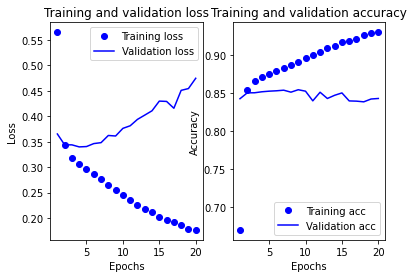

In [20]:
history_chart(history_RNN)

## CNN

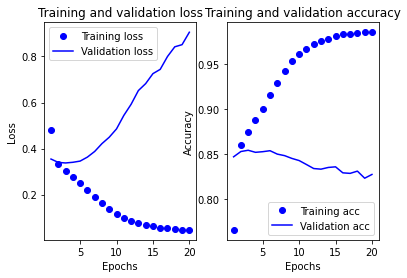

In [21]:
history_chart(history_CNN)

## 단일 GlobalMaxPooling1D

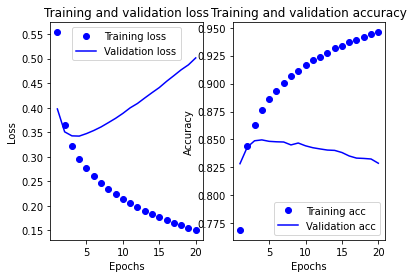

In [22]:
history_chart(history_SG)

## 학습된 Embedding 레이어 분석

---

In [23]:
def Embedding_view(model, word2vec_file_path):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    #print(weights.shape)
    
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고) 만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.get_weights()[0]
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    vector = word_vectors['끝']
    print(vector)
    
    print(word_vectors.similar_by_word("시작"))

In [24]:
word2vec_file_path_RNN = os.getenv("HOME") + '/aiffel/sentiment_classification/data/word2vec_RNN.txt'

Embedding_view(model_RNN, word2vec_file_path_RNN)

[-0.0225656  -0.11432522 -0.05289702  0.02507941  0.09901541 -0.00503873
 -0.3952395  -0.07768479 -0.01952215  0.18937129 -0.08081175 -0.07066838
 -0.02362394 -0.00814318  0.12650637  0.14739458]
[('멈추', 0.9325096607208252), ('평타', 0.9226831793785095), ('19', 0.9177981019020081), ('싸', 0.9143806099891663), ('도라에몽', 0.9134595990180969), ('숙제', 0.8975455164909363), ('몸짓', 0.896268367767334), ('짐', 0.892193078994751), ('경향', 0.891718864440918), ('잖아', 0.8893961310386658)]


In [25]:
word2vec_file_path_CNN = os.getenv("HOME") + '/aiffel/sentiment_classification/data/word2vec_CNN.txt'

Embedding_view(model_CNN, word2vec_file_path_CNN)

[ 0.02588657  0.05012567  0.13944983 -0.00324306 -0.00162057 -0.05429179
 -0.05023568 -0.04196244 -0.09263866  0.02397274  0.0163419  -0.15332821
  0.06318948 -0.05005454  0.053023    0.07134331]
[('연애', 0.7875933051109314), ('어쩔', 0.7854821085929871), ('나미', 0.775702953338623), ('복수', 0.7697166800498962), ('아래', 0.7590108513832092), ('한반도', 0.7513594031333923), ('박스', 0.7222198843955994), ('스승', 0.7141463756561279), ('비치', 0.6968357563018799), ('링컨', 0.6918320059776306)]


In [26]:
word2vec_file_path_SG = os.getenv("HOME") + '/aiffel/sentiment_classification/data/word2vec_SG.txt'

Embedding_view(model_SG, word2vec_file_path_SG)

[-0.01706699  0.03058548 -0.22266284  0.02175904 -0.21262023 -0.1870273
 -0.1424742  -0.23010091 -0.02962578 -0.0261709  -0.25251228  0.05013477
 -0.04830922 -0.17677586  0.00091432  0.11950373]
[('분위기', 0.9569226503372192), ('두', 0.9498953223228455), ('차승원', 0.9350754022598267), ('우주', 0.9327581524848938), ('완전', 0.9325703382492065), ('팬', 0.9236316680908203), ('스런', 0.9186592698097229), ('개인', 0.9157602190971375), ('스럽', 0.9111407399177551), ('곱', 0.8975821733474731)]


직접 만들어서 학습시킨 Embedding 들은 3가지 모델 전부 '시작'라는 단어와는 좀 동떨어진 단어들만 보이는것 같습니다.

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

---

* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.
[참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models),
[참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [27]:
# 예시 코드
word_vectors = Word2VecKeyedVectors.load('../../data/word2vec_ko.model')
vector = word_vectors.wv['시작']
vector

array([-1.16053   ,  3.2086124 , -0.8464585 , -0.21354361,  5.7969356 ,
        0.18993846, -2.6679456 ,  5.1422763 ,  0.70769715,  0.67083716,
       -2.8080425 ,  1.1404599 , -1.367787  , -1.4466493 ,  7.5045366 ,
       -0.9983406 ,  1.5922157 ,  0.59020776,  6.3408074 ,  3.0450768 ,
       -2.4441054 ,  4.4043674 ,  1.6067554 , -4.8582635 ,  0.49741057,
        1.5097246 , -1.6164384 , -2.6722224 ,  1.9465922 ,  4.988424  ,
       -3.884758  ,  2.6203034 ,  3.2578673 ,  1.5888767 , -0.49142   ,
        1.0968636 , -3.5188727 ,  0.17855728,  3.7370596 , -2.685119  ,
        1.320543  , -1.9419105 ,  4.5419254 , -3.970305  ,  0.6959733 ,
       -4.1972575 ,  1.4016238 ,  2.9008312 ,  3.3938718 , -1.2880683 ,
       -1.4832399 , -1.1575463 , -3.10531   , -3.2233114 , -2.1278367 ,
       -4.0140653 , -2.222649  ,  0.9956357 ,  2.4712307 ,  0.32640433,
        0.904556  ,  4.7066073 , -1.6040367 ,  4.9517636 , -1.4919065 ,
       -0.08459547,  2.105639  , -4.060081  , -1.1459922 , -1.19

In [28]:
word_vectors.wv.most_similar('시작')

[('재개', 0.7113743424415588),
 ('개시', 0.6964776515960693),
 ('계속', 0.6593127846717834),
 ('중단', 0.6464443206787109),
 ('진행', 0.6105296611785889),
 ('마무리', 0.5996001958847046),
 ('실시', 0.5984620451927185),
 ('완료', 0.5883207321166992),
 ('전개', 0.5819582343101501),
 ('완성', 0.5794826745986938)]

Word2Vec Embedding 은 상대적으로 유사성이 높은 단어들이 나오고 있습니다.  
가장 높은 유사도에 다시 시작한다는 뜻의 '재개' 가 있네요, 무언가를 시작한다는 뜻의 '개시' 도 있는 것을 보니  
잘 학습된 Embedding 인것 같습니다.

## CNN

In [29]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 90  # 워드 벡터의 차원수
embedding_metrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 복사한다.
for i in range(4, vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

/tmp/ipykernel_11614/1597991925.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in vector:


In [30]:
from tensorflow.keras.initializers import Constant

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_metrix),  # 복사한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))  # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(128, 7, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling1D(5))

model.add(tf.keras.layers.Conv1D(128, 7, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 90)            900000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           80768     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [31]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

history = model.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
532/532 [==============================] - 5s 7ms/step - loss: 0.5274 - accuracy: 0.7102 - val_loss: 0.3782 - val_accuracy: 0.8347
Epoch 2/5
532/532 [==============================] - 3s 6ms/step - loss: 0.3504 - accuracy: 0.8479 - val_loss: 0.3553 - val_accuracy: 0.8428
Epoch 3/5
532/532 [==============================] - 3s 6ms/step - loss: 0.3076 - accuracy: 0.8705 - val_loss: 0.3698 - val_accuracy: 0.8340
Epoch 4/5
532/532 [==============================] - 3s 6ms/step - loss: 0.2788 - accuracy: 0.8865 - val_loss: 0.3699 - val_accuracy: 0.8427
Epoch 5/5
532/532 [==============================] - 3s 6ms/step - loss: 0.2485 - accuracy: 0.9017 - val_loss: 0.3860 - val_accuracy: 0.8333


In [32]:
results = model.evaluate(X_test_post, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3977 - accuracy: 0.8354
[0.397654265165329, 0.8353642225265503]


CNN 쪽은 많이 시도해봤는데 0.85를 잘 못넘네요

### 단일 GlobalMaxPooling1D

In [33]:
SG_model = tf.keras.Sequential()
SG_model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_metrix),  # 복사한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))
SG_model.add(tf.keras.layers.GlobalMaxPooling1D())
SG_model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=('he_normal')))
SG_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
SG_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 90)            900000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 90)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               11648     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 911,777
Trainable params: 911,777
Non-trainable params: 0
_________________________________________________________________


In [34]:
SG_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

SG_history = SG_model.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
532/532 [==============================] - 2s 4ms/step - loss: 0.5015 - accuracy: 0.7572 - val_loss: 0.3680 - val_accuracy: 0.8361
Epoch 2/5
532/532 [==============================] - 2s 3ms/step - loss: 0.3404 - accuracy: 0.8514 - val_loss: 0.3471 - val_accuracy: 0.8468
Epoch 3/5
532/532 [==============================] - 2s 3ms/step - loss: 0.3022 - accuracy: 0.8722 - val_loss: 0.3427 - val_accuracy: 0.8509
Epoch 4/5
532/532 [==============================] - 2s 4ms/step - loss: 0.2769 - accuracy: 0.8849 - val_loss: 0.3397 - val_accuracy: 0.8522
Epoch 5/5
532/532 [==============================] - 2s 4ms/step - loss: 0.2524 - accuracy: 0.8976 - val_loss: 0.3588 - val_accuracy: 0.8488


In [35]:
SG_results = SG_model.evaluate(X_test_post, y_test, verbose=2)

print(SG_results)

1537/1537 - 2s - loss: 0.3765 - accuracy: 0.8429
[0.3764837682247162, 0.842870831489563]


단일 GlobalMaxPooling1D도 조금 부족한것같습니다.

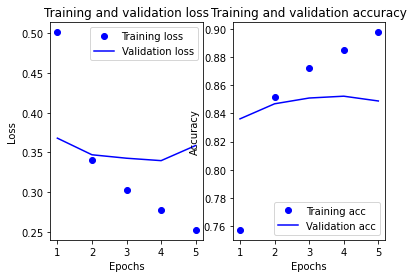

In [36]:
history_chart(SG_history)

## LSTM

In [37]:
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_metrix),  # 복사한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))
LSTM_model.add(tf.keras.layers.LSTM(128))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다.
LSTM_model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 90)            900000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               112128    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 1,045,409
Trainable params: 1,045,409
Non-trainable params: 0
_________________________________________________________________


In [38]:
LSTM_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

LSTM_history = LSTM_model.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
532/532 [==============================] - 6s 8ms/step - loss: 0.5882 - accuracy: 0.6325 - val_loss: 0.3751 - val_accuracy: 0.8359
Epoch 2/5
532/532 [==============================] - 4s 7ms/step - loss: 0.3464 - accuracy: 0.8498 - val_loss: 0.3435 - val_accuracy: 0.8469
Epoch 3/5
532/532 [==============================] - 4s 7ms/step - loss: 0.3063 - accuracy: 0.8700 - val_loss: 0.3275 - val_accuracy: 0.8578
Epoch 4/5
532/532 [==============================] - 4s 7ms/step - loss: 0.2841 - accuracy: 0.8816 - val_loss: 0.3302 - val_accuracy: 0.8592
Epoch 5/5
532/532 [==============================] - 4s 7ms/step - loss: 0.2669 - accuracy: 0.8891 - val_loss: 0.3335 - val_accuracy: 0.8580


In [39]:
results = LSTM_model.evaluate(X_test_post, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3426 - accuracy: 0.8519
[0.34258607029914856, 0.851923406124115]


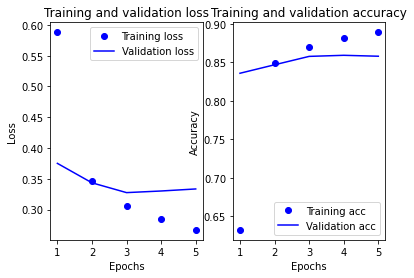

In [40]:
history_chart(LSTM_history)

LSTM은 목표치인 0.85를 넘었습니다.

## BiLSTM

In [41]:
LSTM_B_model = tf.keras.Sequential()
LSTM_B_model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_metrix),  # 복사한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))
LSTM_B_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
LSTM_B_model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
LSTM_B_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
LSTM_B_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 90)            900000    
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 256)           224256    
_________________________________________________________________
dense_12 (Dense)             (None, 41, 256)           65792     
_________________________________________________________________
time_distributed (TimeDistri (None, 41, 1)             257       
Total params: 1,190,305
Trainable params: 1,190,305
Non-trainable params: 0
_________________________________________________________________


In [42]:
LSTM_B_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

LSTM_B_history = LSTM_B_model.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
532/532 [==============================] - 10s 15ms/step - loss: 0.4958 - accuracy: 0.7393 - val_loss: 0.3583 - val_accuracy: 0.8432
Epoch 2/5
532/532 [==============================] - 7s 14ms/step - loss: 0.3444 - accuracy: 0.8511 - val_loss: 0.3342 - val_accuracy: 0.8519
Epoch 3/5
532/532 [==============================] - 7s 14ms/step - loss: 0.3124 - accuracy: 0.8667 - val_loss: 0.3233 - val_accuracy: 0.8584
Epoch 4/5
532/532 [==============================] - 7s 14ms/step - loss: 0.2881 - accuracy: 0.8787 - val_loss: 0.3264 - val_accuracy: 0.8573
Epoch 5/5
532/532 [==============================] - 7s 14ms/step - loss: 0.2712 - accuracy: 0.8859 - val_loss: 0.3199 - val_accuracy: 0.8586


In [43]:
results = LSTM_B_model.evaluate(X_test_post, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3272 - accuracy: 0.8553
[0.3271730840206146, 0.8553208112716675]


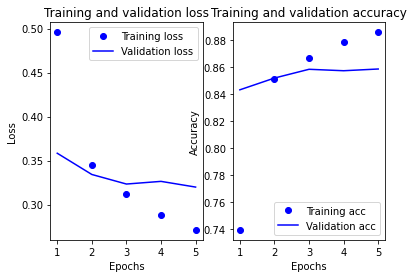

In [44]:
history_chart(LSTM_B_history)

LSTM에 Bidirectional을 추가해봤는데 좀 더 양호하네요.

## BiLSTM with Attention mechanism

In [45]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [46]:
sequence_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
embedded_sequences = tf.keras.layers.Embedding(vocab_size, 128, input_length=maxlen, mask_zero = True)(sequence_input)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, return_state=True))(lstm)

In [47]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 41, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [48]:
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

dense1 = tf.keras.layers.Dense(20, activation="relu", kernel_initializer='he_normal')(context_vector)
#dropout = tf.keras.layers.Dropout(0.3)(dense1)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dense1)
model_a = tf.keras.Model(inputs=sequence_input, outputs=output)

In [49]:
model_a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_a = model_a.fit(partial_X_train_post,
                   partial_y_train, epochs=3, batch_size = 256, validation_data=(X_val_post, y_val), verbose=1)

Epoch 1/3
532/532 [==============================] - 31s 35ms/step - loss: 0.3959 - accuracy: 0.8197 - val_loss: 0.3336 - val_accuracy: 0.8533
Epoch 2/3
532/532 [==============================] - 14s 27ms/step - loss: 0.3188 - accuracy: 0.8618 - val_loss: 0.3225 - val_accuracy: 0.8589
Epoch 3/3
532/532 [==============================] - 15s 28ms/step - loss: 0.2856 - accuracy: 0.8774 - val_loss: 0.3186 - val_accuracy: 0.8623


In [50]:
print("\n 테스트 정확도: %.4f" % (model_a.evaluate(X_test_post, y_test)[1]))

1537/1537 [==============================] - 12s 8ms/step - loss: 0.3289 - accuracy: 0.8578

 테스트 정확도: 0.8578


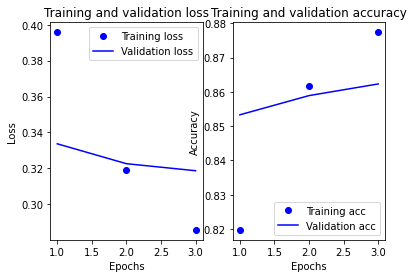

In [51]:
history_chart(history_a)

# 회고

* CNN, 단일 GlobalMaxPooling1D를 사용할때는 목표치인 85%에 아슬아슬한데, LSTM은 약 1% 성능이 좋아서 높아서 85%를 넘을 수 있었습니다.
* BiLSTM과 Attention mechanism을 같이 사용하는 방법을 시도해 봤습니다. 해당 방법은 RNN의 마지막 은닉 상태까지 도달하면서 소실된 정보들을  다시 참고하기 위해 RNN의 모든 은닉 상태들을 다시 참고해서 정확도를 높이는 방법입니다.
    * 해당 방법으로 시도했을 때, BiLSTM보다 조금 더 좋은 성능을 보여주고 있습니다.

### 참고자료

* BiLSTM with Attention mechanism  
https://wikidocs.net/22893  
https://wikidocs.net/73161  
https://wikidocs.net/48920